In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=4

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"dataset",
shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 1144 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['LUAD', 'LUSC', 'others']

In [5]:
len(dataset)

36

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 0 2 0 0 0 2 1 0 0 0 0 0 0 2 2 0 0 1 0 0 1 0 0 0 2 0 0 0]


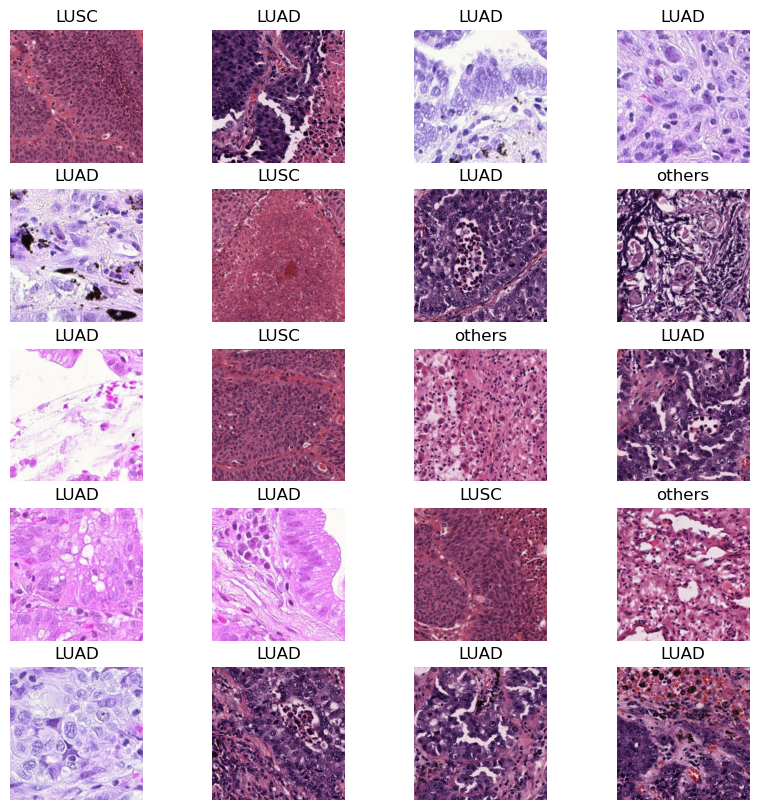

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
     for i in range(20):
       ax = plt.subplot(5,4,i+1)
       plt.imshow(image_batch[i].numpy().astype("uint8"))
       plt.title(class_names[label_batch[i]])
       plt.axis("off")

In [8]:
len(dataset)

36

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

28

In [12]:
len(val_ds)

3

In [13]:
len(test_ds)

5

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
from keras.applications import ResNet101V2
convlayer=ResNet101V2(input_shape=(256,256,3),weights='imagenet',include_top=False)
for layer in convlayer.layers:
    layer.trainable=False

In [17]:
model=models.Sequential()
model.add(convlayer)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(225,activation='softmax'))


In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 8, 8, 2048)        42626560  
                                                                 
 dropout (Dropout)           (None, 8, 8, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 batch_normalization (BatchN  (None, 131072)           524288    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              268437504 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                      

In [53]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy','tf.keras.metrics.AUC(from_logits=True)',
             'sklearn.metrics.roc_curve(y_true, y_score, *, pos_label=None, sample_weight=None, drop_intermediate=True)',
            'tf.math.confusion_matrix(labels,predictions,num_classes=None,weights=None,dtype=tf.dtypes.int32,name=None)',
             'sklearn.metrics.f1_score(y_true, y_pred, *, labels=None, pos_label=1,sample_weight=None)'
            ]
)

In [52]:
history = model.fit(
    train_ds,
    epochs=4,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
28/28 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.9572WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000021E5DD91DC8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

In [21]:
ores = model.evaluate(test_ds)

5/5 [==============================] - 19s 4s/step - loss: 0.1091 - accuracy: 0.9625


In [22]:
history.params

{'verbose': 1, 'epochs': 4, 'steps': 28}

In [23]:
history.history.keys()   

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(acc,val_acc)

loss = history.history['loss']
val_loss = history.history['val_loss']
print(loss,val_loss)

[0.8051801919937134, 0.9408482313156128, 0.9639639854431152, 0.96875] [0.6354166865348816, 0.8333333134651184, 0.9270833134651184, 0.9583333134651184]
[0.8499189019203186, 0.1682579070329666, 0.10186915844678879, 0.08624105900526047] [18.16322135925293, 2.1450488567352295, 0.361439973115921, 0.16221116483211517]


Text(0.5, 1.0, 'Training and Validation Accuracy')

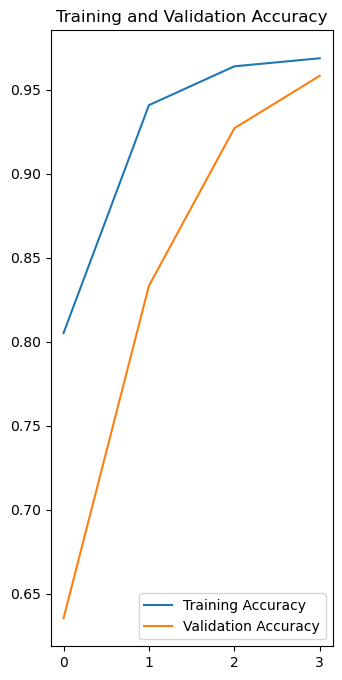

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

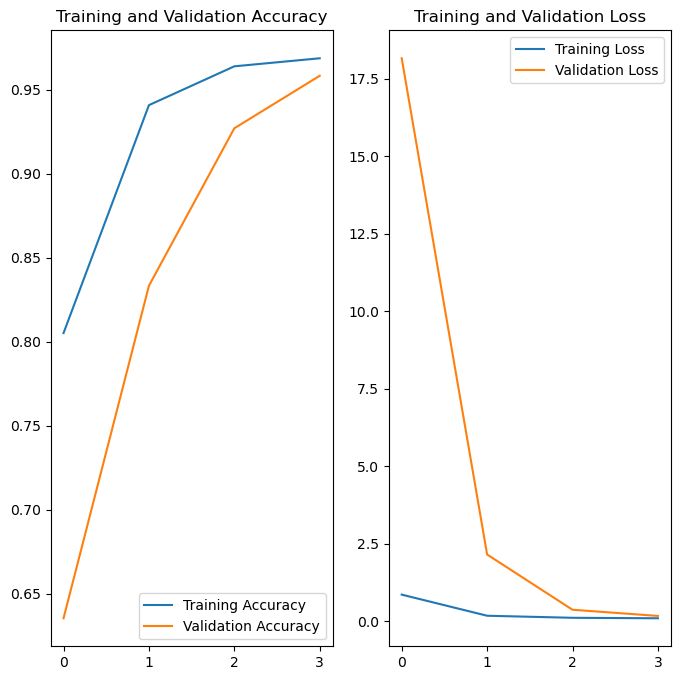

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')

plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: LUAD
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 5s 5s/step
predicted label: LUAD


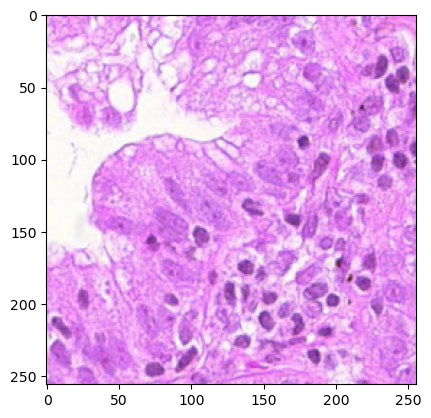

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
  
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #creating batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 307ms/step


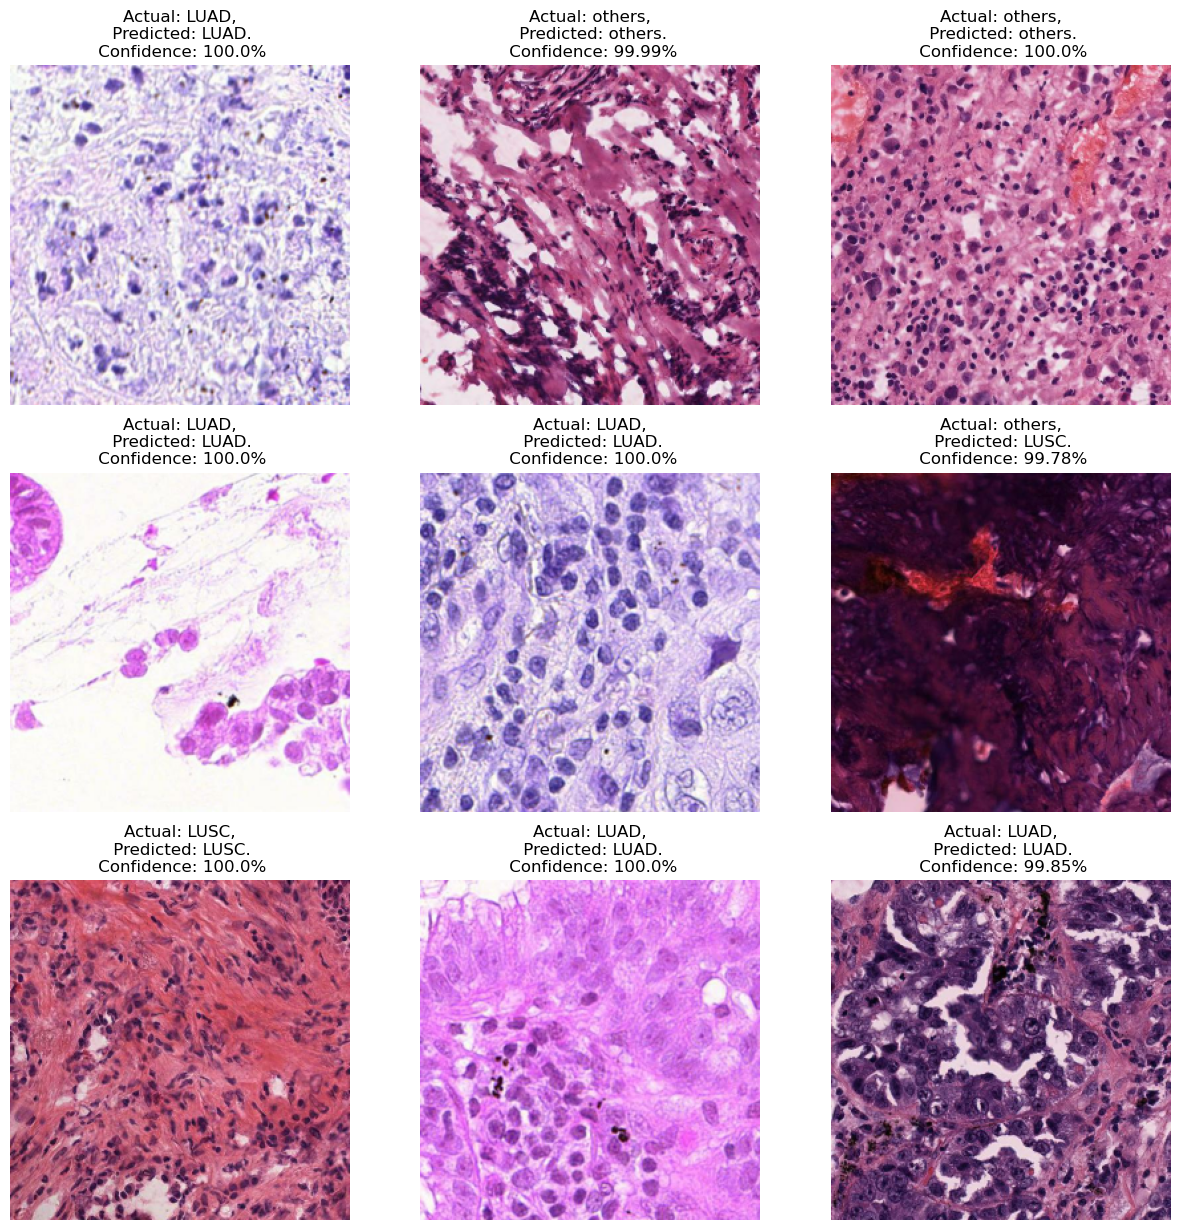

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
model.save('myModel.h5')

In [ ]:
new_model = tf.keras.models.load_model('myModel.h5') #same file path

In [ ]:
new_model.summary()